# Error Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import re
import spacy
from IPython.display import display
import dateutil.parser as dateutil_parser
from string import punctuation
from tqdm import tqdm
from config import Config
config = Config()
import utils
import eval.evaluate

%matplotlib inline

# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

nlp = spacy.load('en_core_web_sm')


In [2]:
# Ignores some problems on my system
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## Dataset and predictions loading

In [3]:
TEST_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'dev_set.json')
VAL_DATASET_PATH = os.path.join(config.ROOT_PATH, 'data', 'validation_set.json')

PATH_TO_PREDICTIONS_TEST = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_test_tpu.txt')
PATH_TO_PREDICTIONS_VAL = os.path.join(config.ROOT_PATH, 'src', 'eval', 'normal_predictions_val_tpu.txt')
PATH_TO_PREDICTIONS_BERT = os.path.join(config.ROOT_PATH, 'src', 'eval', 'BERT_predictions_test_tpu.txt')

In [4]:
test_data = utils.read_question_set(TEST_DATASET_PATH)
validation_data = utils.read_question_set(VAL_DATASET_PATH)

prediction_test = utils.read_question_set(PATH_TO_PREDICTIONS_TEST)
prediction_val = utils.read_question_set(PATH_TO_PREDICTIONS_VAL)
prediction_test_bert = utils.read_question_set(PATH_TO_PREDICTIONS_BERT)

## Question categorization

The dataset contains many different types of questions and answers: some are related to dates, some other to people, other to places and so on. We want to understand how well our model performs on these different types of questions.

First of all, we must partition the questions into their types. We do this by understanding whether the related answer is numerical (cardinal) or non-numerical. Non-numerical answers are further categorized using NER tags and the associated tag is linked to the question. 


In [5]:
def is_numeric(answer:str):
    # A pattern that recognizes only-numerical answers
    return re.match('[0-9–]+', answer)

def is_date(answer:str):
    # We use a function from the dateutil module to understand 
    # if a given answer contains a date.
    try:
        dateutil_parser.parse(answer, fuzzy=False)
        return True
    except:
        return False
        
def get_question_type(question, answer):
    # We parse the answer using spacy's library
    answer = answer.strip(punctuation)
    doc = nlp(answer)

    for token in doc: 
        # print(f"{token.text:{8}} {token.dep_+' =>':{10}}   {token.head.text:{9}} {token.ent_type_}")
        if token.ent_type_:
            # If we find an entity type in the answer, we return it
            return (token.ent_type_).lower()
    # Otherwise we check if the answer is a date...
    if is_date(answer):
        return 'date'
    # ... a number...
    if is_numeric(answer):
        return 'cardinal'
    # ... if the question contains "Who"...
    if question[:3].lower() == "who":
        return "person"
    # ... and if the answer is none of these categories and it's quite long, we consider it 
    # a "clause"...
    if len(doc) >4:
        return "clause"
    # ... or "other".
    return "other"

We apply this analysis on the *test dataset* using the predictions made by our *normal* model.

In [6]:
def split_questions_type(data, prediction):
    questions_type = []
    # Iterate over all questions and answers of the test set
    for article in tqdm(data['data']):
        for paragraph in article['paragraphs']:
            for question_and_answer in paragraph["qas"]:

                qid = question_and_answer['id']
                # Obtain the ground truth answers
                gold_answers = [a['text'] for a in question_and_answer['answers']]
                # Obtain our prediction
                a_pred = prediction[qid]
                # Compute the exact and F1 score between this and the best-scoring GT answer
                exact_score = max(eval.evaluate.compute_exact(a, a_pred) for a in gold_answers)
                f1_score = max(eval.evaluate.compute_f1(a, a_pred) for a in gold_answers)
                # We get the answer, the question, the question type and the context
                answer = random.sample(gold_answers, 1)[0]
                question = question_and_answer["question"]
                question_type = get_question_type(question, answer)
                context = paragraph["context"]
                # ... and we append all of these details into the list.
                questions_type.append([question_type, question, answer, a_pred, context, f1_score, exact_score])
                # errors.append([question_type, question, context, answer])
    return questions_type

In [7]:
# We are then able to put all of these data into a dataframe
df = pd.DataFrame(split_questions_type(test_data, prediction_test), columns=["type", "question", "answer", "prediction", "context", "f1-score", "exact-score"])
df.head()

100%|██████████| 48/48 [02:12<00:00,  2.76s/it]


,type,question,answer,prediction,context,f1-score,exact-score
0,person,Which NFL team represented the AFC at Super Bo...,Denver Broncos,Denver Broncos,Super Bowl 50 was an American football game to...,1.0,1
1,person,Which NFL team represented the NFC at Super Bo...,Carolina Panthers,Carolina Panthers,Super Bowl 50 was an American football game to...,1.0,1
2,gpe,Where did Super Bowl 50 take place?,"Santa Clara, California",Levi's Stadium,Super Bowl 50 was an American football game to...,1.0,1
3,person,Which NFL team won Super Bowl 50?,Denver Broncos,Denver Broncos,Super Bowl 50 was an American football game to...,1.0,1
4,other,What color was used to emphasize the 50th anni...,gold,"gold-themed initiatives, as well as temporaril...",Super Bowl 50 was an American football game to...,0.0,0


Here, we use spacy to explain each of the tags from our dataset:

In [8]:
for type in df["type"].unique():
    print("Tag: '{}' --> {}".format(type, spacy.explain(type.upper())))

Tag: 'person' --> People, including fictional
Tag: 'gpe' --> Countries, cities, states
Tag: 'other' --> None
Tag: 'date' --> Absolute or relative dates or periods
Tag: 'org' --> Companies, agencies, institutions, etc.
Tag: 'loc' --> Non-GPE locations, mountain ranges, bodies of water
Tag: 'cardinal' --> Numerals that do not fall under another type
Tag: 'product' --> Objects, vehicles, foods, etc. (not services)
Tag: 'ordinal' --> "first", "second", etc.
Tag: 'event' --> Named hurricanes, battles, wars, sports events, etc.
Tag: 'fac' --> Buildings, airports, highways, bridges, etc.
Tag: 'time' --> Times smaller than a day
Tag: 'clause' --> None
Tag: 'money' --> Monetary values, including unit
Tag: 'percent' --> Percentage, including "%"
Tag: 'norp' --> Nationalities or religious or political groups
Tag: 'quantity' --> Measurements, as of weight or distance
Tag: 'work_of_art' --> Titles of books, songs, etc.
Tag: 'language' --> Any named language
Tag: 'law' --> Named documents made into 

Let's see the score divided on each category.

In [9]:
scores_by_group = []

for key in df["type"].unique():
    f1_score = df[df["type"] == key]["f1-score"].sum()
    exact_score = df[df["type"] == key]["exact-score"].sum()
    total = len(df[df["type"] == key]["f1-score"])
    scores_by_group.append([key, f1_score/total, exact_score/total, total])

scores_by_group = pd.DataFrame(scores_by_group, columns=['CATEGORY', 'F1 SCORE', 'EXACT SCORE', 'NUMBER OF ELEMENTS'])
scores_by_group.sort_values(by='NUMBER OF ELEMENTS', ascending=False)

,CATEGORY,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS
2,other,0.740545,0.610995,3820
0,person,0.815780,0.749153,1475
6,cardinal,0.712494,0.510545,1138
3,date,0.734859,0.543971,1103
4,org,0.798474,0.674627,1005
12,clause,0.745465,0.560316,887
1,gpe,0.713694,0.543430,449
15,norp,0.772218,0.572052,229
5,loc,0.793347,0.640000,125
8,ordinal,0.686142,0.487179,78


We check how many questions have a *completely wrong* answer, where we consider *completely wrong* as having an F1-Score less than 0.5 with the groundtruth.

In [10]:
F1_THRESHOLD=0.5

high_errors_df = df[df["f1-score"] < F1_THRESHOLD]
error_df = pd.DataFrame(high_errors_df.groupby("type", as_index=True).size().reset_index()).rename(columns={0: 'WRONG ANSWERS'})
errors_by_group = scores_by_group.merge(error_df, how='left', left_on='CATEGORY', right_on='type')[
        ['CATEGORY', 'F1 SCORE','EXACT SCORE', 'NUMBER OF ELEMENTS', 'WRONG ANSWERS']
    ]
errors_by_group['WRONG RATIO'] = errors_by_group['WRONG ANSWERS'] / errors_by_group['NUMBER OF ELEMENTS']
errors_by_group = errors_by_group.set_index('CATEGORY')
errors_by_group.sort_values('WRONG RATIO', ascending=False)

,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS,WRONG ANSWERS,WRONG RATIO
CATEGORY,,,,,
time,0.744444,0.636364,22,6.0,0.272727
ordinal,0.686142,0.487179,78,21.0,0.269231
gpe,0.713694,0.543430,449,117.0,0.260579
other,0.740545,0.610995,3820,903.0,0.236387
clause,0.745465,0.560316,887,209.0,0.235626
cardinal,0.712494,0.510545,1138,256.0,0.224956
date,0.734859,0.543971,1103,236.0,0.213962
loc,0.793347,0.640000,125,24.0,0.192000
norp,0.772218,0.572052,229,43.0,0.187773


From this analysis, we can see that our model gets really wrong a lot of questions about **numbers**, be it *cardinal numbers*, *money* or *quantities*. We can explain this by the fact that the tokenizer probably splits numbers that are not *common*, ignoring the fact that a number has value on its own, not just as a word.

Long answers which don't have a clear type are also a problem.

We show the kinds of mistakes our model makes using the following pie charts:

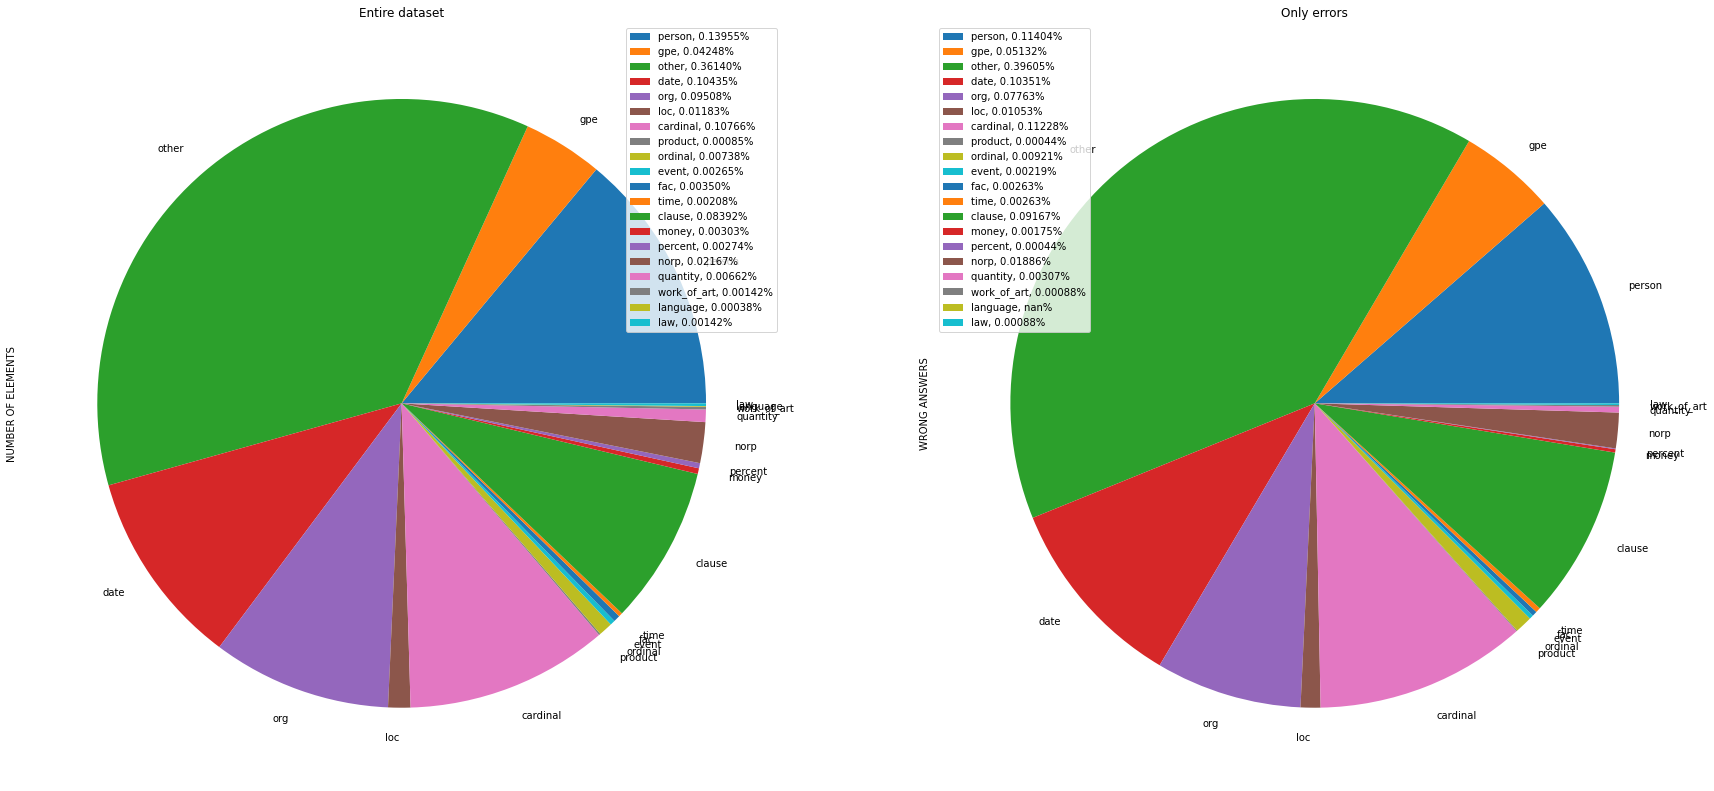

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Entire dataset")
errors_by_group.plot.pie(y='NUMBER OF ELEMENTS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['NUMBER OF ELEMENTS']/errors_by_group['NUMBER OF ELEMENTS'].sum())]
ax1.legend(labels)

ax2.set_title("Only errors")
errors_by_group.plot.pie(y='WRONG ANSWERS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['WRONG ANSWERS']/errors_by_group['WRONG ANSWERS'].sum())]

ax2.legend(labels)

The quantities of errors overall match the data distribution.

Now, we analyze some of the errors for each question category:

In [13]:
errors_by_group_sorted = errors_by_group.sort_values(by='WRONG ANSWERS', ascending=False)

for key in list(errors_by_group_sorted.index):
    if len(high_errors_df[high_errors_df["type"]==key])>1:
        samples = high_errors_df[high_errors_df["type"]==key].drop(["f1-score", "exact-score"], axis=1).sample(1)
        print(key)
        display(samples)
    print()

other


,type,question,answer,prediction,context
8226,other,What were later Yuan emperors disinterested in?,administration,intrigues and rivalries. Uninterested in admin...,The final years of the Yuan dynasty were marke...



person


,type,question,answer,prediction,context
2445,person,Which of Luther's hymn was the main one for Ad...,"Nun komm, der Heiden Heiland",Hauptlied,"Luther wrote ""Ach Gott, vom Himmel sieh darein..."



cardinal


,type,question,answer,prediction,context
4320,cardinal,What is the estimate for the amount of tree sp...,"16,000",390 billion,The Amazon rainforest (Portuguese: Floresta Am...



date


,type,question,answer,prediction,context
4247,date,What year was the ECSC agreement established?,1951,1951 following the second World War. The agree...,EU Competition law has its origins in the Euro...



clause


,type,question,answer,prediction,context
6499,clause,What is the ability to recognize and adapt to ...,Adaptive (or acquired) immunity,"Jawed vertebrates, including humans, have even...","Pathogens can rapidly evolve and adapt, and th..."



org


,type,question,answer,prediction,context
3893,org,"Where did Golovin work prior to joining the ""S...",NASA,to monitor,But even after NASA reached internal agreement...



gpe


,type,question,answer,prediction,context
852,gpe,Where is the Jazz Jamboree hosted?,Warsaw,Warsaw Summer Jazz Days,"Thanks to numerous musical venues, including t..."



norp


,type,question,answer,prediction,context
3017,norp,What armed group stopped the uprising at Balla...,British troops,"miners protesting against mining taxes (the ""E...",In 1854 at Ballarat there was an armed rebelli...



loc


,type,question,answer,prediction,context
7017,loc,What region does use the term 'private schools...,North America,"Australia and Canada, the use of the term is g...",In the United Kingdom and several other Common...



ordinal


,type,question,answer,prediction,context
2059,ordinal,What follows secondary education?,tertiary education,(secondary schools/high schools,Education in Australia is primarily the respon...



quantity


,type,question,answer,prediction,context
7300,quantity,What is the land area of Jacksonville?,874.3 square miles,"874.3 square miles (2,264 km2), making Jackson...","According to the United States Census Bureau, ..."



fac


,type,question,answer,prediction,context
131,fac,What Florida stadium was considered for Super ...,Sun Life Stadium,"Sun Life Stadium, and the San Francisco Bay Ar...",The league eventually narrowed the bids to thr...



time


,type,question,answer,prediction,context
2607,time,At what time did Martin Luther die?,2:45 a.m,18 February 1546,An apoplectic stroke deprived him of his speec...



event


,type,question,answer,prediction,context
9907,event,When were Joseph Schumpeter and Norman Angell ...,"before World War I,",(1872–1967). While these non-Marxist writers w...,"The correlation between capitalism, aristocrac..."



money


,type,question,answer,prediction,context
7004,money,What is the average construction salary in the...,"£26,719","£42,090",In 2010 a salary survey revealed the differenc...



work_of_art


,type,question,answer,prediction,context
2365,work_of_art,When did Luther and his wife live?,", ""The Black Cloister,""",1525–32,Luther and his wife moved into a former monast...



law


,type,question,answer,prediction,context
4099,law,What are the core treaties that the primary la...,the Treaty on European Union (TEU) and the Tre...,Treaty on European Union,The primary law of the EU consists mainly of t...


We can see that:
- Some errors are related to having a few words more or less with respect to the ground truth answer
    - For instance, questions related to years often repeat a large part of the context, while the ground truth answer is simply the year.
- There are lots of errors that are due to our implementation of the answer extraction. 
    - Since the output indices are related to the sequence of tokens and not to the words in the paragraph, we actually decode the previously encoded tokens to extract the answer.
    - But this creates answers that are not necessarily part of the paragraph
    - Therefore, they may be valid answers (and in some of the presented cases, they are), but they are not *exactly* equal to the ground truth due to the addition of spaces or lowercase/uppercase letters
    - These are problems related to the tokenizer that have a huge impact in the performances
    - A solution to this problem might be changing the way we produce an answer by keeping track of the index transformation between tokens and character indices in the paragraph.
    - Or, in alternative, comparing our predicted answer to a decoded ground truth using the same tokenizer we used for the paragraph and the question.


## Dataset split difference

We have noticed a big difference in performances between validation and test sets, so we need to investigate this gap.

In [14]:
df_val = pd.DataFrame(split_questions_type(validation_data, prediction_val), columns=["type", "question", "answer", "prediction", "context", "f1-score", "exact-score"])

df_val.head()

100%|██████████| 111/111 [04:13<00:00,  2.28s/it]


,type,question,answer,prediction,context,f1-score,exact-score
0,other,k,ks,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
1,other,j,Ch,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
2,other,n,n,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
3,other,b,b,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0
4,other,v,v,"ROC, Jing","Nanjing ( listen; Chinese: 南京, ""Southern Capit...",0.0,0


First of all there are a bit of junk both in question and in the answer. 

In [15]:
junky_questions = df_val[df_val["question"].str.len()<6]

print("junky question information")
print("number of question with less than 6 character:", junky_questions.shape[1])


junky question information
number of question with less than 6 character: 7


Still there aren't enough junky questions to justify the gap.

Let's see the score divided for each category.

In [17]:
scores_by_group_val = []

for key in df_val["type"].unique():
    f1_score = df_val[df_val["type"] == key]["f1-score"].sum()
    exact_score = df_val[df_val["type"] == key]["exact-score"].sum()
    total = len(df_val[df_val["type"] == key]["f1-score"])
    scores_by_group_val.append([key, f1_score/total, exact_score/total, total])

scores_by_group_val = pd.DataFrame(scores_by_group_val, columns=['CATEGORY', 'F1 SCORE', 'EXACT SCORE', 'NUMBER OF ELEMENTS'])
scores_by_group_val.sort_values(by='NUMBER OF ELEMENTS', ascending=False)

,CATEGORY,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS
0,other,0.681425,0.505766,6677
6,person,0.801788,0.692622,2941
4,date,0.678085,0.408512,2749
5,cardinal,0.676832,0.437956,2740
3,org,0.731489,0.551518,2009
7,clause,0.601553,0.303393,2004
1,gpe,0.625031,0.429635,1478
9,norp,0.670898,0.453829,888
2,loc,0.691614,0.507812,256
11,ordinal,0.592016,0.284884,172


And the score about the questions that we consider *completely wrong*.

In [18]:
F1_THRESHOLD=0.5

high_errors_df_val = df_val[df_val["f1-score"] < F1_THRESHOLD]
error_df_val = pd.DataFrame(high_errors_df_val.groupby("type", as_index=True).size().reset_index()).rename(columns={0: 'WRONG ANSWERS'})
errors_by_group_val = scores_by_group_val.merge(error_df_val, how='left', left_on='CATEGORY', right_on='type')[
        ['CATEGORY', 'F1 SCORE','EXACT SCORE', 'NUMBER OF ELEMENTS', 'WRONG ANSWERS']
    ]
errors_by_group_val['WRONG RATIO'] = errors_by_group_val['WRONG ANSWERS'] / errors_by_group_val['NUMBER OF ELEMENTS']
errors_by_group_val = errors_by_group_val.set_index('CATEGORY')
errors_by_group_val.sort_values('WRONG RATIO', ascending=False)

,F1 SCORE,EXACT SCORE,NUMBER OF ELEMENTS,WRONG ANSWERS,WRONG RATIO
CATEGORY,,,,,
clause,0.601553,0.303393,2004,752,0.375250
gpe,0.625031,0.429635,1478,549,0.371448
percent,0.622892,0.352113,71,24,0.338028
ordinal,0.592016,0.284884,172,54,0.313953
norp,0.670898,0.453829,888,266,0.299550
law,0.704789,0.513514,37,11,0.297297
work_of_art,0.670997,0.323529,34,10,0.294118
language,0.767571,0.476190,21,6,0.285714
loc,0.691614,0.507812,256,72,0.281250


We still have not found a reason for such gap, so we compare the data distribuition of test set and the validation set.

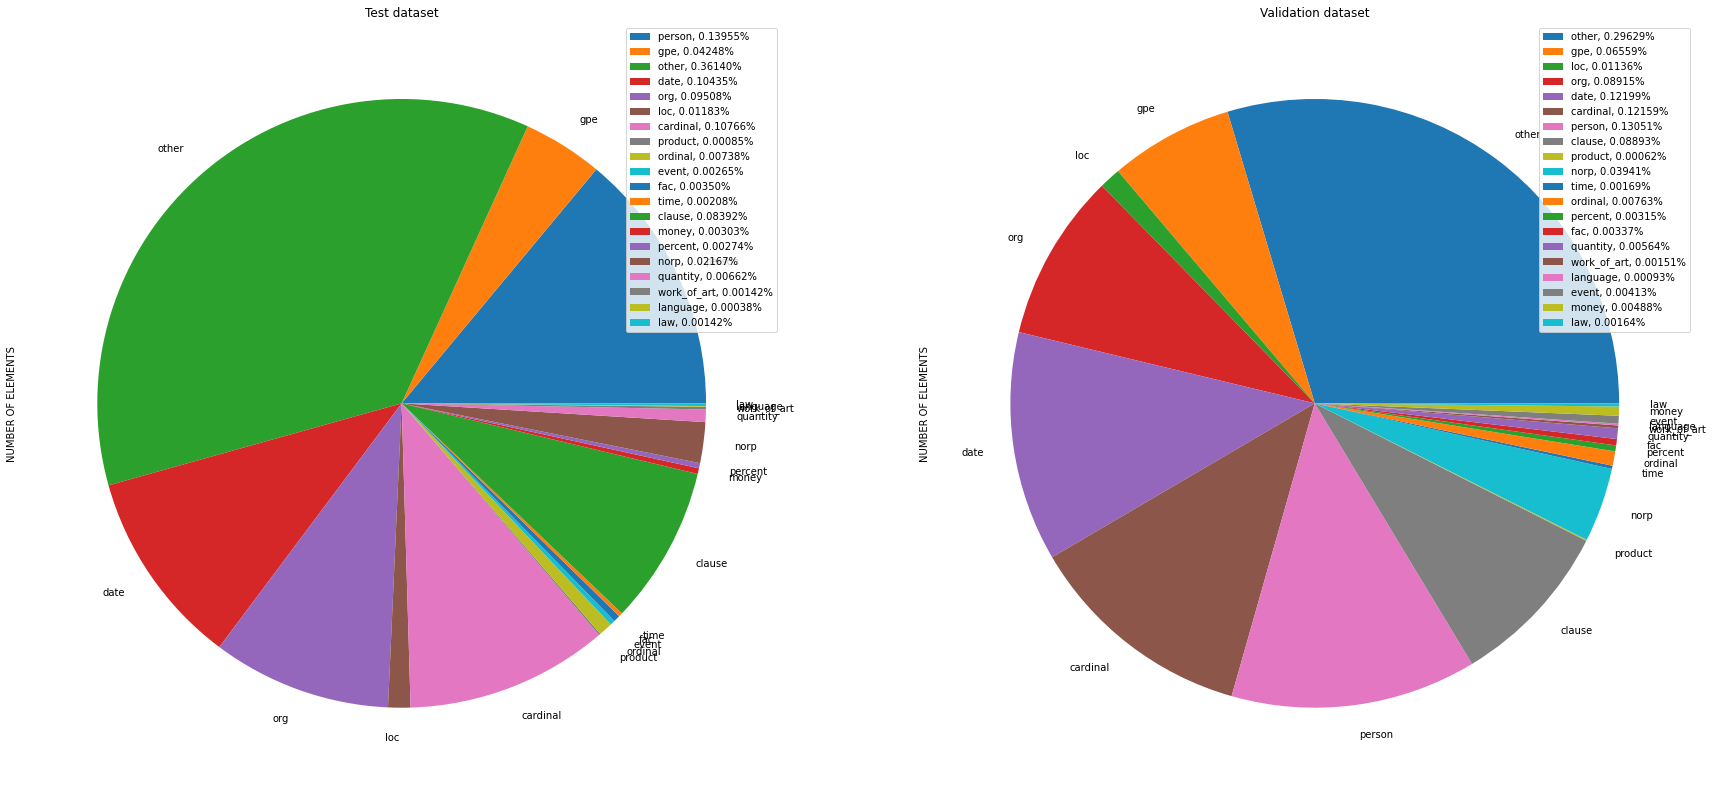

In [19]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Test dataset")
errors_by_group.plot.pie(y='NUMBER OF ELEMENTS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['NUMBER OF ELEMENTS']/errors_by_group['NUMBER OF ELEMENTS'].sum())]
ax1.legend(labels)
ax2.set_title("Validation dataset")
errors_by_group_val.plot.pie(y='NUMBER OF ELEMENTS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group_val.index), 
    errors_by_group_val['NUMBER OF ELEMENTS']/errors_by_group_val['NUMBER OF ELEMENTS'].sum())]
ax2.legend(labels)

We also compare the error distribution:

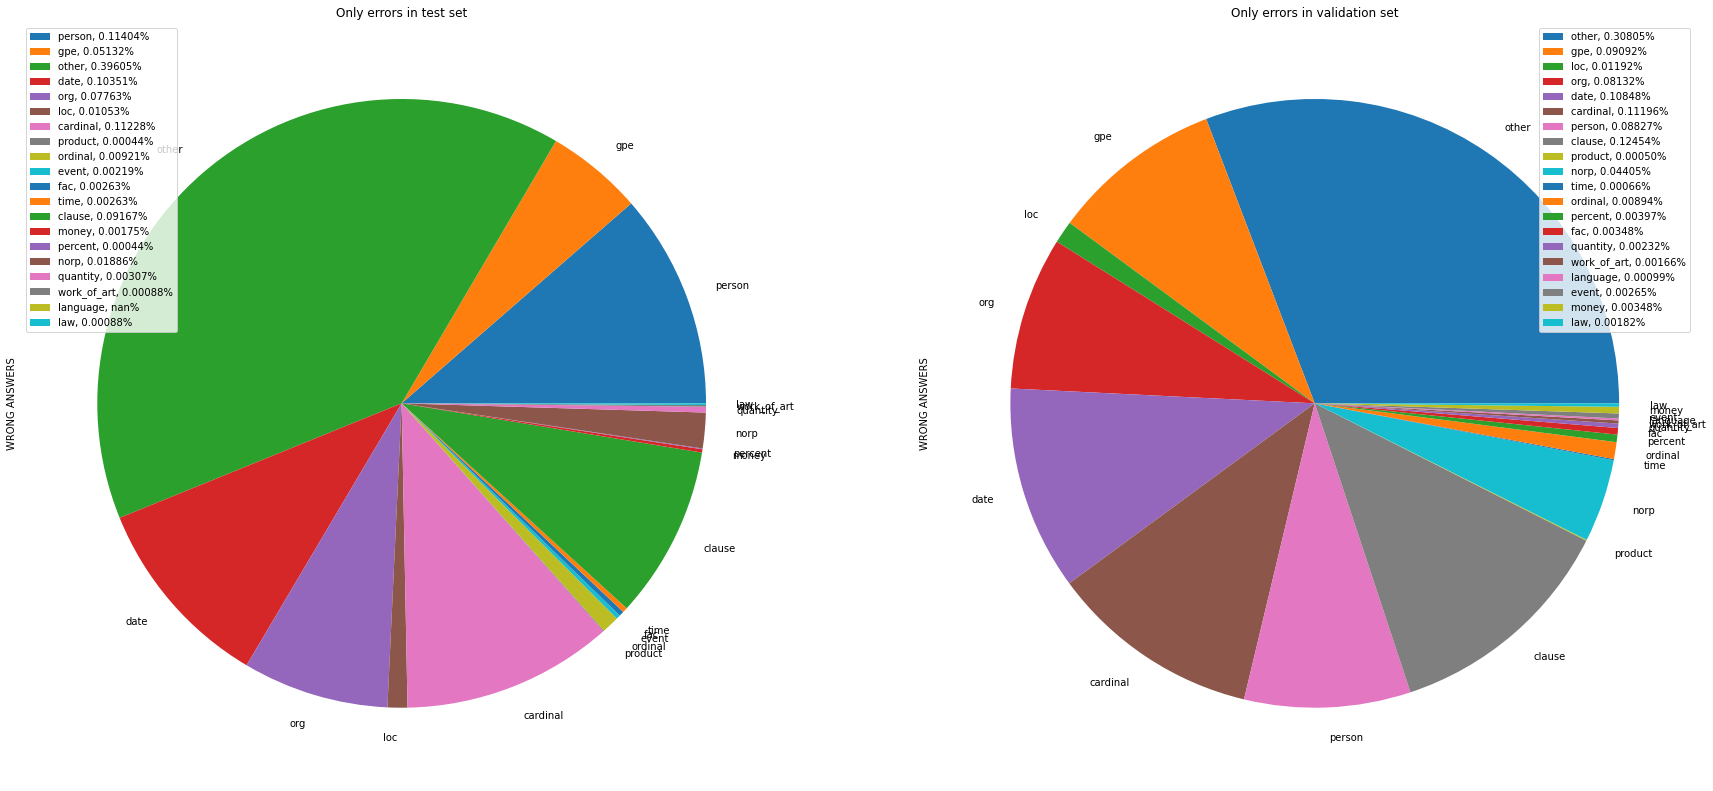

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,30))
ax1.set_title("Only errors in test set")
errors_by_group.plot.pie(y='WRONG ANSWERS', ax=ax1);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group.index), 
    errors_by_group['WRONG ANSWERS']/errors_by_group['WRONG ANSWERS'].sum())]
ax1.legend(labels)
ax2.set_title("Only errors in validation set")
errors_by_group_val.plot.pie(y='WRONG ANSWERS', ax=ax2);
labels = [f'{l}, {s:0.5f}%' for l, s in zip(list(errors_by_group_val.index), 
    errors_by_group_val['WRONG ANSWERS']/errors_by_group_val['WRONG ANSWERS'].sum())]
ax2.legend(labels)

the data distribution and the error distribution are overrall the same for both the data set.